### Ổn định số học và khởi tạo
- Việc lựa chọn cơ chế khởi tạo rất lớn trong quá trình học của mạng Nơ ron và có thể là yếu tố quyết định để duy trì sự ổn định số học.
- Việc lựa chọn hàm kích hoạt và cách khởi tạo tham số có thể ảnh hưởng đến tốc độ hội tụ của thuật toán tối ưu. Nếu ta không lựa chọn hợp lý, việc bùng nổ hoặc tiêu biến gradient sẽ xảy ra.
- Trong phần này ta sẽ đi sâu hơn vào các chi tiết của chủ đề này và thảo luận một số phương pháo thực nghiệm hữu ích mà ta có thể sẽ sử dụng thường xuyên trong suốt sự nghiệp Deep learning.

#### 1. Tiêu biến và bùng nổ gradient
- Xét một MLP với L tầng, đầu vào X và đầu ra o. Mõi tầng l được định nghĩa bởi một phép biến đổi f_l với tham số là trọng số W_l. Mạng nơ ron này được biểu diễn như sau:

    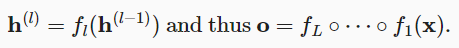

- Nếu tất cả giá trị kích hoạt và đầu vào là vector, ta có thể viết lại gradient của o theo một tập tham số W_l bất kỳ như sau:

    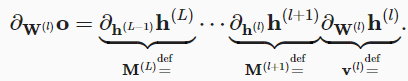

- Nói cách khác, gradient này là tích của L - l ma trận M_L,..., M_l với vector gradient v_l. Vì vậy, ta sẽ dễ gặp phải vấn đề tràn số dưới, một hiện tượng thường xảy ra khi nhân quá nhiều giá trị xác suất lại với nhau. 
- Khi làm việc với xác suất, một trick phổ biến là chuyển về làm việc với giá trị log của nó. Nếu nhìn từ góc độ biểu diễn số học, điều này đồng nghĩa với việc chuyển trọng tâm biểu diễn của các bit từ phần định trị (mantissa) sang phần mũ (exponent). 
- Tuy nhiên, các ma trận M_l ban đầu có thể có nhiều trị riêng với độ lớn rất khác nhau. Các trị riêng có thể nhỏ hoặc lớn và do đó tích của chúng có thể rất lớn hoặc rất nhỏ.
- Các ma trận M_l ban đầu có thể biểu diễn được bằng các trị riêng và các vector riêng A = Q * X * Q ^-1, với Q là ma trận trực giao chứa các vector riêng làm cột, X là ma trận đường chéo chứa các trị riêng.
- Rủi ro của việc gradient bất ổn không chỉ dừng lại ở vấn đề biểu diễn số học. Nếu ta không thể kiểm soát được độ lớn của gradient, sự ổn định của các thuật toán cũng không được đảm bảo. Lúc đó ta sẽ quan sát được các bước cập nhật hoặc quá lớn hoặc quá nhỏ -> việc học trở nên bất khả thi.

#### Vanishing gradient
- Thông thường, thủ phạm gây ra vấn đề vanishing gradient này là hàm kích hoạt được chọn để đặt nối tiếp phép toán tuyến tính tại mỗi tầng. Trước đây, hàm kích hoạt sigmoid(x) = 1/(1 + e^(-x)), ta xem xét hàm này để thấy tại sao nó có thể gây ra vấn đề tiêu biến gradient.

In [1]:
from d2l import mxnet as d2l
from mxnet import autograd, np, npx
from matplotlib import pyplot as plt
npx.set_np()

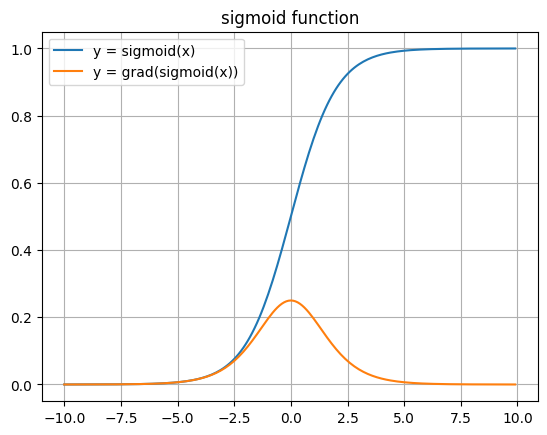

In [2]:
x = np.arange(-10, 10, 0.1)
x.attach_grad()

with autograd.record():
    y = npx.sigmoid(x)
y.backward()

fig, ax = plt.subplots(nrows = 1, ncols= 1)

ax.set_title(label = "sigmoid function")
ax.plot(x, npx.sigmoid(x), label = "y = sigmoid(x)")
ax.legend()
ax.plot(x, x.grad, label = "y = grad(sigmoid(x))")
ax.legend()
ax.grid(visible = True)

- Như ta thấy, gradient của hàm sigmoid tiêu biến khi đầu vào của nó quá lớn hoặc quá nhỏ, hơn nữa, khi thực hiện lan truyền ngược qua nhiều tầng, trừ khi giá trị nằm trong vùng Goldilocks, tại đó đầu vào của hầu hết các hàm sigmoid có giá trị xấp xỉ không, gradient của cả phép nhân sẽ bị tiêu biến.
- Khi mạng nơ ron nhiều tầng, trừ khi ta cẩn trọng, nhiều khả năng luồng gradient sẽ bị ngắt ở một tầng nào đó.
- vấn đề này đã từng gây nhiều khó khăn cho quá trình huấn luyện mạng nơ ron. Do đó, hàm ReLU ổn định hơn đã và đang dần trở thành lựa chọn mặc định của những người làm học sâu.

#### Exploding gradient
- Một vấn đề đối lập với vanishing gradient là bùng nổ gradient. Để giải thích việc này, ta lấy 100 ma trận ngẫu nhiêu gauss và nhân chúng với một ma trận ban đầu nào đó. Với khoảng giá trị mà ta chọn phương sai = 1, tích các ma trận bị bùng nổ số học.
- Khi khởi tạo các mạng nơ ron sâu một cách không hợp lý thì các bộ tối ưu dựa trên hạ gradient sẽ không hội tụ được.

In [3]:
M = np.random.normal(loc = 0, scale = 1, size = (4, 4))
print("M = ", M)

for i in range(100):
    M = np.dot(M, np.random.normal(size = (4, 4)))

print("After multiplying 100 matrices generated by gaussian distribution:", M)

M =  [[ 1.1630785   2.2122061   0.4838046   0.7740038 ]
 [ 0.29956347  1.0434403   0.15302546  1.1839255 ]
 [-1.1688148   1.8917114   1.558071   -1.2347414 ]
 [-0.5459446  -1.771029   -2.3556297  -0.45138448]]
After multiplying 100 matrices generated by gaussian distribution: [[ 2.7097458e+23 -7.9017529e+22 -2.8474295e+22 -3.7432810e+22]
 [ 5.7055964e+22 -1.6637811e+22 -5.9956017e+21 -7.8813207e+21]
 [-4.6633711e+23  1.3598619e+23  4.9003136e+22  6.4420651e+22]
 [-8.3223900e+22  2.4268480e+22  8.7450706e+21  1.1497510e+22]]


#### Tính đối xứng
- Một vấn đề khác trong việc thiết kế mạng nơ ron sâu là tính đỗi ứng hiện hữu trong quá trình tham số hóa.
- Giả sử trong trường hợp này, ta có thể hoán vị trọng số W1 của tầng đầu tiên, rồi làm điều tương tự với các trọng số của tầng đầu ra để thu được một hàm giống hệt ban đầu. Ta có thể thấy rằng không có sự khác biệt nào giữa nút ẩn đầu tiên với nút ẩn thứ hai, nói cách khác, ta có tính đối xứng hoán vị giữa các nút ẩn của từng tầng.
- Nếu ta khởi tạo giá trị của mọi tham số ở các tầng như sau: W_l = C với hằng số C nào đó, trường hợp này thì các gradient cho tất cả các chiều đều giống hệt nhau, nên mỗi nút không chỉ có cùng giá trị mà chúng còn có bước cập nhật giống nhau. Bản thân phương pháp hạ gradient ngâu nhiên không thể phá vỡ tính đối xứng này và ta không thể hiện thực hóa được sức mạnh biểu diễn của mạng. tầng ẩn sẽ hoạt động như thể chỉ có một nút duy nhất.
- Tuy nhiên, dù hạ gradient ngẫu nhiên không thể phá vỡ được tính đối xứng nhưng với điều chuẩn dropout thì có thể.

### 2. Khởi tạo tham số
- Một cách giải quyết hay ít nhất giảm thiểu các vấn đề được nêu trên là khởi tạo tham số một cách cẩn thận.
- Chỉ cần cẩn trọng một chút trong quá trình tối ưu hóa và điều chuẩn mô hình phù hợp thì ta có thể cải thiện tính ổn định của quá trình học.

#### 2.1 Khởi tạo mặc định
- Ta đã sử dụng net.initialize(init.Normal(sigma = 0.01)) để khởi tạo các giá trị cho trọng số. 
- Nếu ta không chỉ định sẵn một phương thức khởi tạo như net.initialize(), MXNet sẽ sử dụng phương thức khởi tạo ngẫu nhiên mặc định: Các trọng số được lấy mẫu ngẫu nhiên từ phân phối đều U[-0.07, 0.07] còn các hệ số điều chỉnh đều được đưa về giá trị 0.
- Cả hai lựa chọn trên đều hoạt động tốt với các bài toán cỡ trung trong thực tiễn.